<a href="https://colab.research.google.com/github/2022Group3/projectNotebooks/blob/main/analize_dirty_label_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import load_model
import numpy as np
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model=load_model(r'drive/MyDrive/dirty_label_model.h5')
csv_data= pd.read_csv(r'drive/MyDrive/data.csv')

In [ ]:
def load_dataset():
  data=np.load(r'drive/MyDrive/data_modified_new_labels.npz')
  data=dict(zip(("{}".format(k) for k in data),(data[k] for k in data)))
  trainX=data['train']
  trainy=data['ytrain']
  validationX=data['validation']
  validationy=data['yvalidation']
  testX=data['test']
  testy=data['ytest']
  return trainX,trainy,validationX,validationy,testX,testy

In [ ]:
# scale pixels
def prep_pixels(testX):
  # convert from integers to floats
  testX_norm = testX.astype('float32')
  # normalize to range 0-1
  testX_norm = testX_norm / 255.0
  
  # return normalized images
  return testX_norm

In [ ]:
trainX,trainy,validationX,validationy,testX,testy=load_dataset()

In [ ]:
x_test=testX
testX=prep_pixels(testX)
y_test=testy
testy=to_categorical(testy)

In [ ]:
pred=model.predict(testX)

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    plt.xticks(rotation=90, ha='right')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [ ]:
unique_df=csv_data.drop_duplicates(subset = "label_name").sort_values("current_label_number")
unique_df

,image_name,batch_label,original_label_number,current_label_number,label_name,dataset,train/validation/test
6,fighter_aircraft_s_000655.png,data_batch_1,0,0,airplane,cifar10,train
5,convertible_s_002032.png,test_batch,1,1,automobile,cifar10,train
18,skylark_s_000150.png,data_batch_1,2,2,bird,cifar10,train
1,house_cat_s_000535.png,data_batch_1,3,3,cat,cifar10,train
13,rangifer_caribou_s_001065.png,test_batch,4,4,deer,cifar10,train
27,chihuahua_s_002224.png,test_batch,5,5,dog,cifar10,train
2,bufo_viridis_s_001453.png,test_batch,6,6,frog,cifar10,train
46,appaloosa_s_002139.png,data_batch_3,7,7,horse,cifar10,train
14,sea_boat_s_002208.png,data_batch_5,8,8,ship,cifar10,train
10,wrecker_s_001619.png,data_batch_2,9,9,truck,cifar10,train


In [ ]:
labels=unique_df['label_name']
labels


6                 airplane
5               automobile
18                    bird
1                      cat
13                    deer
27                     dog
2                     frog
46                   horse
14                    ship
10                   truck
8                     fish
0                  flowers
35    fruit_and_vegetables
12                  people
3                    trees
Name: label_name, dtype: object

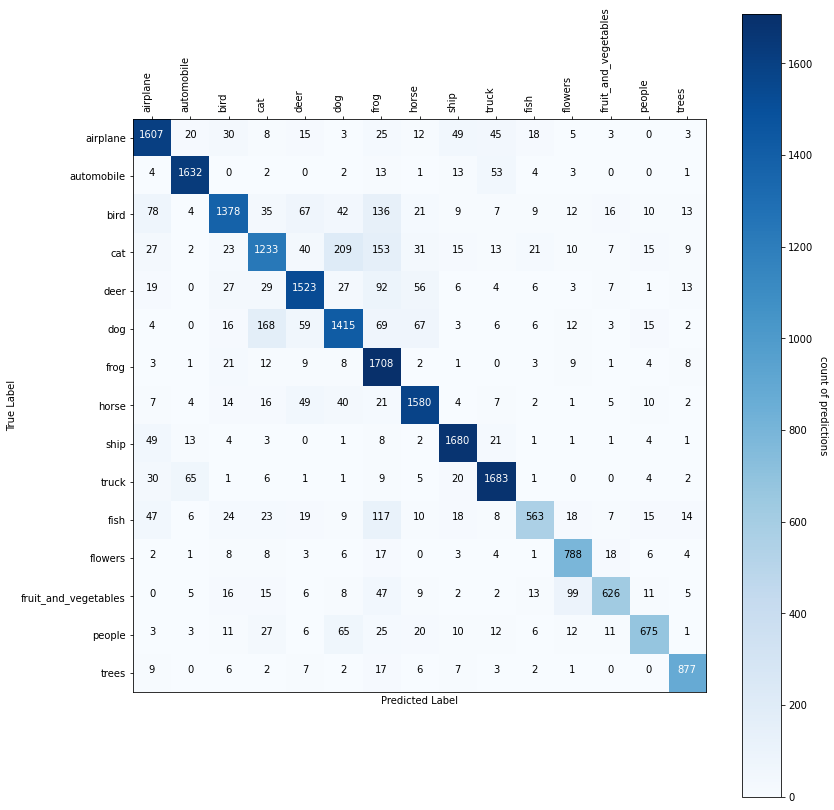

In [ ]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(testy, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)



# Y_pred_classes_errors = Y_pred_classes[errors]
# Y_pred_errors = pred[errors]
# Y_true_errors = Y_true[errors]
# X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [ ]:
cm

array([[1607,   20,   30,    8,   15,    3,   25,   12,   49,   45,   18,
           5,    3,    0,    3],
       [   4, 1632,    0,    2,    0,    2,   13,    1,   13,   53,    4,
           3,    0,    0,    1],
       [  78,    4, 1378,   35,   67,   42,  136,   21,    9,    7,    9,
          12,   16,   10,   13],
       [  27,    2,   23, 1233,   40,  209,  153,   31,   15,   13,   21,
          10,    7,   15,    9],
       [  19,    0,   27,   29, 1523,   27,   92,   56,    6,    4,    6,
           3,    7,    1,   13],
       [   4,    0,   16,  168,   59, 1415,   69,   67,    3,    6,    6,
          12,    3,   15,    2],
       [   3,    1,   21,   12,    9,    8, 1708,    2,    1,    0,    3,
           9,    1,    4,    8],
       [   7,    4,   14,   16,   49,   40,   21, 1580,    4,    7,    2,
           1,    5,   10,    2],
       [  49,   13,    4,    3,    0,    1,    8,    2, 1680,   21,    1,
           1,    1,    4,    1],
       [  30,   65,    1,    6,    1,

In [ ]:
def analyze_confusion_matrix(confusion_matrix,class1):
  TP=confusion_matrix[class1][class1]
  TN=0
  FP=0
  FN=0
  for i in range(len(confusion_matrix)):
    if i==class1:
      continue
    TN+=confusion_matrix[i][i]
    FP+=confusion_matrix[i][class1]
    FN+=confusion_matrix[class1][i]
  return TP,TN,FP,FN

In [ ]:
def calculate(TP,TN,FP,FN):
  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  f1_score=2*(recall*precision)/(recall+precision)
  return recall,precision,f1_score

In [ ]:
y=[]
for i in range(len(cm)):
  TP,TN,FP,FN=analyze_confusion_matrix(cm,i)
  recall,precision,f1_score=calculate(TP,TN,FP,FN)
  y.append(precision)
  

In [ ]:
x=len(y)
x=np.arange(x)

In [ ]:
x=labels

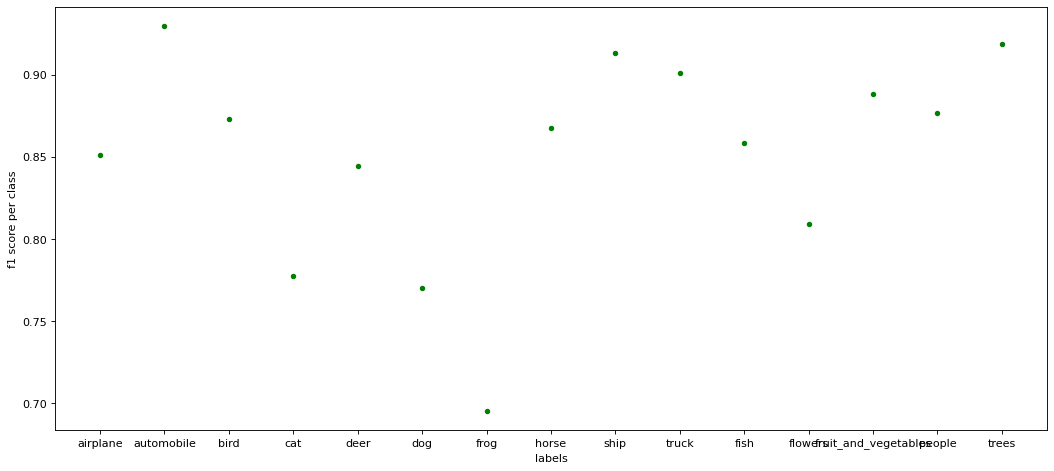

In [ ]:
plt.figure(figsize=(16, 7), dpi=80)

plt.scatter(x,y,s=15,c ="green")
plt.xlabel("labels")
plt.ylabel("f1 score per class")
plt.show()

In [ ]:
# TP,TN,FP,FN=analyze_confusion_matrix(confusion_matrix,index)

In [ ]:
classes_y = np.argmax(testy, axis=1)
classes_pred = np.argmax(pred, axis=1)
errors=classes_y!=classes_pred
true=classes_y==classes_pred
np.unique(classes_pred)



array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
label_number=np.array(unique_df['current_label_number'])
label_name=np.array(unique_df['label_name'])
label_name

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck', 'fish', 'flowers',
       'fruit_and_vegetables', 'people', 'trees'], dtype=object)

In [ ]:
labels_dict=dict(zip(label_number, label_name))
labels_dict
# labels_dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck',11:'fish',12:'flowers',13:'food_containers',14:'fruit_and_vegetables',15:'household_electrical_devices'}


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
 10: 'fish',
 11: 'flowers',
 12: 'fruit_and_vegetables',
 13: 'people',
 14: 'trees'}

In [ ]:
def something_from_false_predict(param,errors):
  res=[]
  for i in range(len(errors)):
    if errors[i]==True:
      res.append(param[i])
  res=np.array(res)
  return res

In [ ]:
def show_false_sample(images,targets,true_target,sample_size=24, title_text='Digit {}' ):
    '''
    Visualize random digits in a grid plot
    images - array of flatten gidigs [:,784]
    targets - final labels
    '''
    nsamples=sample_size
    rand_idx = np.random.choice(len(images),nsamples)
    images_and_pred_and_true_target = list(zip(images[rand_idx], targets[rand_idx],true_target[rand_idx]))


    img = plt.figure(1, figsize=(15, 12), dpi=160)
    for index, (image, pred,true_target) in enumerate(images_and_pred_and_true_target):
        plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)
        plt.axis('off')
        #each image is flat, we have to reshape to 2D array 28x28-784
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title("predict: "+pred+"\n actual: "+true_target)

In [ ]:
test_x_show=something_from_false_predict(x_test,errors)
y_pred=something_from_false_predict(classes_pred,errors)
y_true=something_from_false_predict(classes_y,errors)

y_classes=something_from_false_predict(classes_y,errors)
pred_classes=something_from_false_predict(classes_pred,errors)

In [ ]:
def str_target(label_number):
  target=[]
  for i in range(len(label_number)):
    target.append(labels_dict[label_number[i]])
  target=np.array(target)
  return target


In [ ]:
true_target=str_target(y_true)
false_target=str_target(y_pred)

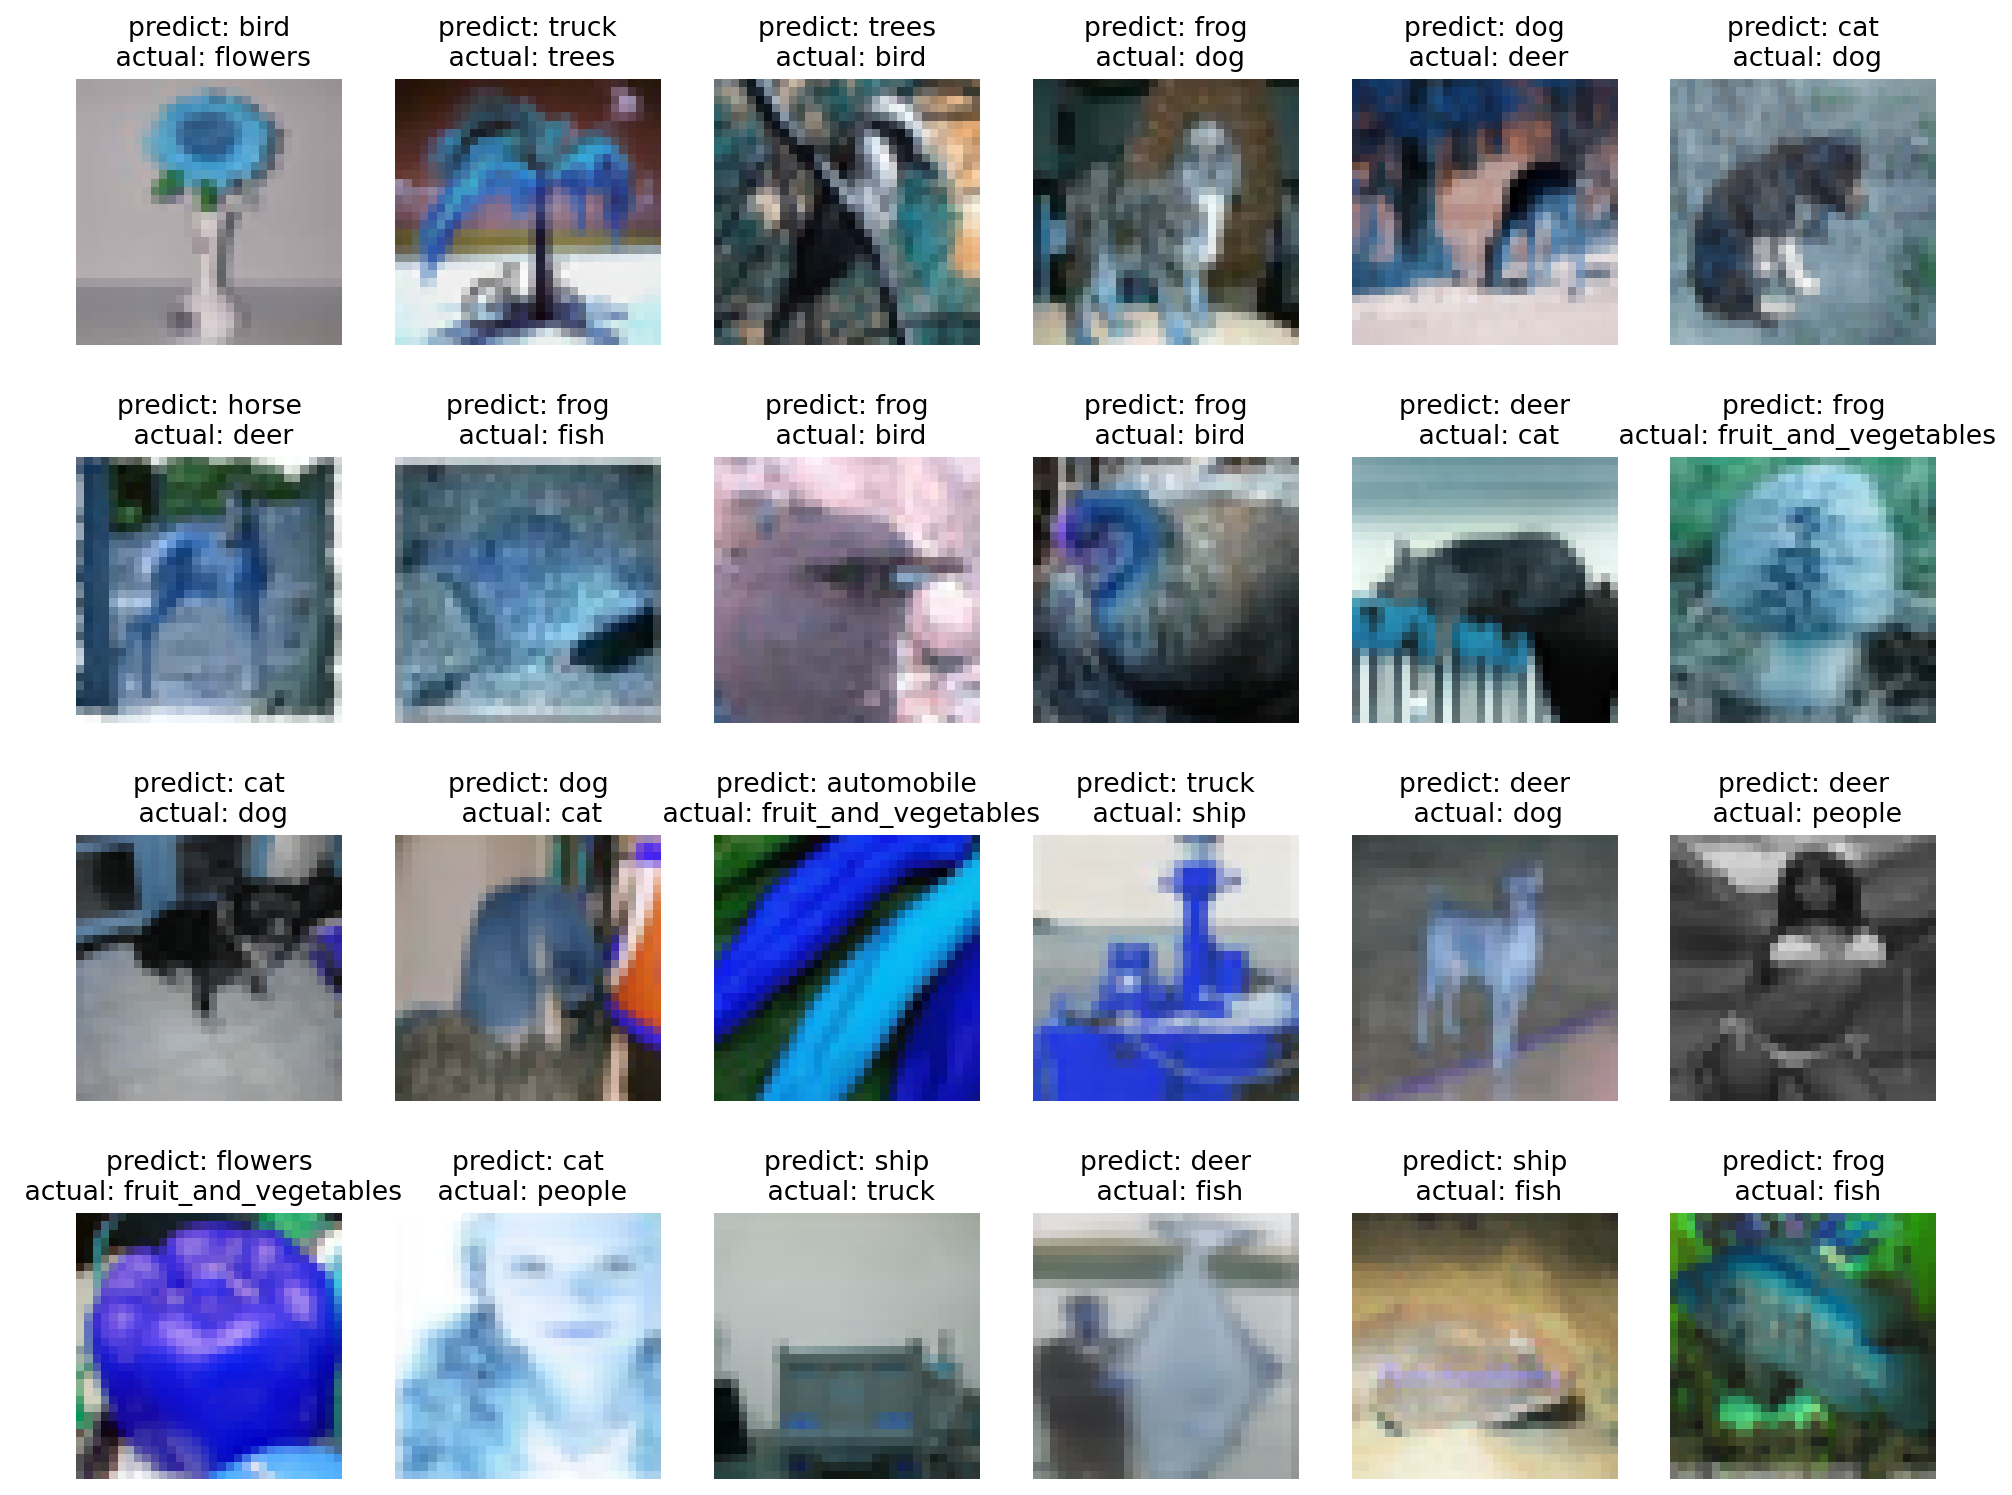

In [ ]:
show_false_sample(test_x_show,false_target,true_target)

In [ ]:
_,acc = model.evaluate(testX,testy, verbose=0)

In [ ]:
acc

0.8430222272872925

In [ ]:
accuracy=true.sum()/len(y_test)
accuracy

0.8430222222222222

In [ ]:
pred

array([[2.3851281e-03, 1.6717140e-03, 2.7384134e-03, ..., 3.1611407e-03,
        6.4089336e-04, 1.9669035e-03],
       [9.0368725e-03, 3.4678397e-03, 2.9983646e-01, ..., 1.0732498e-02,
        9.2646778e-02, 3.2498275e-03],
       [3.2475382e-02, 8.2716849e-03, 1.1518364e-02, ..., 9.0454211e-03,
        6.6717872e-03, 3.0755594e-02],
       ...,
       [9.6614160e-05, 9.8905879e-01, 6.6931196e-04, ..., 6.3982944e-04,
        3.9317977e-04, 2.3685591e-03],
       [2.7159059e-03, 6.5751123e-04, 9.2024446e-01, ..., 2.8595424e-03,
        2.0189616e-03, 6.8613893e-04],
       [1.9519050e-04, 7.9704354e-05, 3.5149020e-05, ..., 6.7863672e-04,
        5.4337888e-05, 9.1203008e-05]], dtype=float32)

In [ ]:
try_pred = np.copy(pred)

In [ ]:
classes_x1=np.argmax(try_pred,axis=1)

In [ ]:
prob_class_x1=np.max(try_pred,axis=1)
prob_class_x1[0]

0.8814012

In [ ]:
for i in range(len(classes_x1)):
  try_pred[i,classes_x1[i]]=0.0
  # print(try_pred[i])

classes_x2=np.argmax(try_pred, axis=1)
prob_class_x2=np.max(try_pred, axis=1)
prob_class_x2[0]

0.05744795

In [ ]:
true2=classes_x2==classes_y
true2

array([False, False,  True, ..., False, False, False])

In [ ]:
accuracy2=(true.sum()+true2.sum())/len(true2)
accuracy2

0.9318666666666666

find threshold

In [ ]:
errors_img=[i for i in range(len(errors)) if errors[i]==True]
true_img=[i for i in range(len(errors)) if errors[i]==False]

In [ ]:

dif=abs(prob_class_x1-prob_class_x2)
dif

array([0.8239532 , 0.03872392, 0.36143243, ..., 0.9866902 , 0.8659048 ,
       0.99675435], dtype=float32)

In [ ]:
dif_error_img=dif[errors_img]
dif_true_img=dif[true_img]

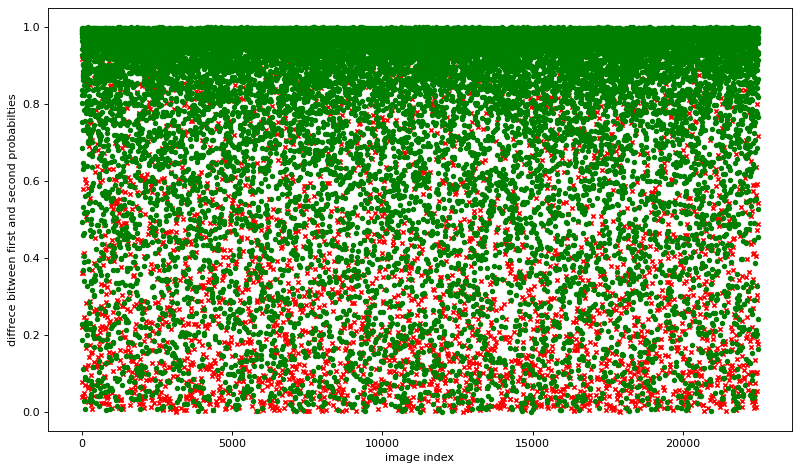

In [ ]:
plt.figure(figsize=(12, 7), dpi=80)

plt.scatter(errors_img, dif_error_img,s=15, c ="red",
            linewidths = 10,
            marker ="x")
            # edgecolor ="green",
            # s = 50)
 
plt.scatter(true_img, dif_true_img,s=15, c ="green")
            # linewidths = 2,
            # marker ="^",)
            # edgecolor ="red",
            # s = 200)
 
plt.xlabel("image index")
plt.ylabel("diffrece bitween first and second probabilties")
plt.show()

In [ ]:
true_first_prob_second_prob=true2
for i in range(len(true)):
  if true[i] ==True:
    true_first_prob_second_prob[i]=True
true_first_prob_second_prob
# true_first_prob_second_prob=[x for x in true if x==True ]
len(true_first_prob_second_prob)

22500

In [ ]:
ea=[i for i in range(len(true_first_prob_second_prob)) if true_first_prob_second_prob[i]==False]
tb=[i for i in range(len(true_first_prob_second_prob)) if true_first_prob_second_prob[i]==True]


In [ ]:
e_y_dif=dif[ea]
t_y_dif=dif[tb]

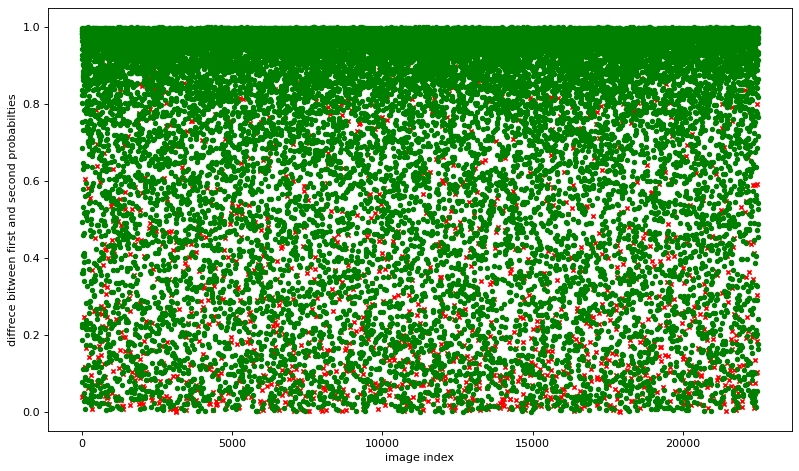

In [ ]:
plt.figure(figsize=(12, 7), dpi=80)

plt.scatter(ea, e_y_dif,s=15, c ="red",
            linewidths = 10,
            marker ="x")
            # edgecolor ="green",
            # s = 50)
 
plt.scatter(tb, t_y_dif,s=15, c ="green")
            # linewidths = 2,
            # marker ="^",)
            # edgecolor ="red",
            # s = 200)
 
plt.xlabel("image index")
plt.ylabel("diffrece bitween first and second probabilties")
plt.show()

threshold out of distribution

In [ ]:
sum_of_first_and_second_prob=prob_class_x1-prob_class_x2
sum_of_first_and_second_prob

array([0.8239532 , 0.03872392, 0.36143243, ..., 0.9866902 , 0.8659048 ,
       0.99675435], dtype=float32)

In [ ]:
sum_error_img=sum_of_first_and_second_prob[errors_img]
sum_true_img=sum_of_first_and_second_prob[true_img]

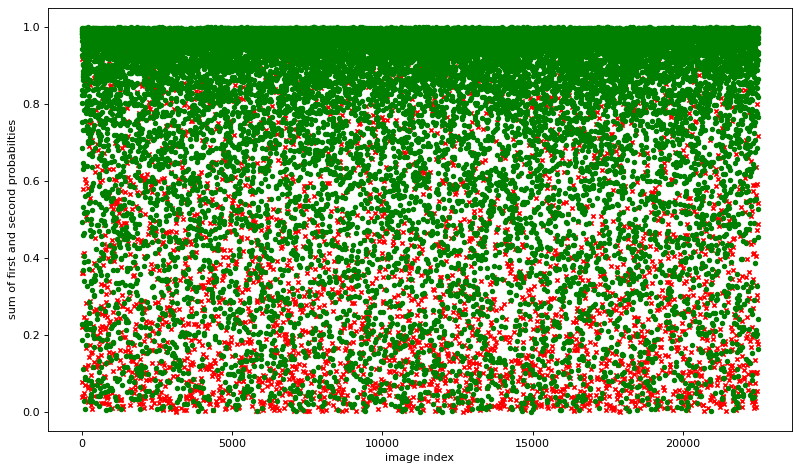

In [ ]:
plt.figure(figsize=(12, 7), dpi=80)

plt.scatter(errors_img, sum_error_img,s=15, c ="red",
            linewidths = 10,
            marker ="x")
            # edgecolor ="green",
            # s = 50)
 
plt.scatter(true_img, sum_true_img,s=15, c ="green")
            # linewidths = 2,
            # marker ="^",)
            # edgecolor ="red",
            # s = 200)
 
plt.xlabel("image index")
plt.ylabel("sum of first and second probabilties")
plt.show()